In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor


Load Original Dataset and Split into Price Categories 

In [2]:
#drop Venue and EventID
df = pd.read_csv("data/complete/ticket_sales.csv").drop(["Venue", "EventId"], axis=1)

#create new target variable Revenue 
df["Revenue"] = df["Booked Tickets"] * df["AVG Price"]

#remove some of the Price cateogories 
df = df[~df["Price Category"].isin(["Gehbehinderte", "Rollstuhlfahrer*in", "Rollstuhlfahrer:in", "Rollstuhlfahrer*in Begleitung", "Sehbehinderte", "Rollstuhlfahrer Begleitung", "Rollstuhlfahrer", "Gehörlose", "Gastbereich"   ])]


#Split the Dataset into the different Price Categories 
categories = df["Price Category"].unique()

split_datasets = {category: df[df["Price Category"] == category] for category in categories}


Load kat1 Price Category as an Example 

In [3]:
#drop Price Category as a feature and reomve the year from the competition 
dfkat1 = pd.read_csv("data/category/kat1.csv").drop(["Price Category"], axis=1) 
dfkat1['Competition'] = dfkat1['Competition'].str.replace(r'\s+\d{4}/\d{2}', '', regex=True).str.strip()


Encode Features 

In [4]:
# One-Hot Encoding for Competition and EventName
encoder = OneHotEncoder(sparse_output=False)
columns_to_encode = ['Competition', 'EventName']
encoded_data = encoder.fit_transform(dfkat1[columns_to_encode])
encoded_column_names = encoder.get_feature_names_out(columns_to_encode)
encoded_df = pd.DataFrame(encoded_data, columns=encoded_column_names)


final_df = pd.concat([
    dfkat1.drop(columns=columns_to_encode), 
    encoded_df,  
], axis=1)


#Encode the features of the Time/Date
final_df['Date'] = pd.to_datetime(final_df['Date'])
final_df['Year'] = final_df['Date'].dt.year
final_df['Month'] = final_df['Date'].dt.month
final_df['DayOfWeek'] = final_df['Date'].dt.dayofweek  # 0 = Monday, 6 = Sunday

final_df['Kick-off Time'] = pd.to_datetime(final_df['Kick-off Time'])
final_df['Hour'] = final_df['Kick-off Time'].dt.hour
final_df['Minute'] = final_df['Kick-off Time'].dt.minute

final_df = final_df.dropna()


C:\Users\fidel\AppData\Local\Temp\ipykernel_8812\4247438290.py:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  final_df['Kick-off Time'] = pd.to_datetime(final_df['Kick-off Time'])


Train-Test Split

In [5]:
X = final_df.drop(columns=["Revenue", "Date", "Kick-off Time", "AVG Price", "Booked Tickets"])  # Drop Target Variable as well as all other features not available at time of prediction 
Y = final_df["Revenue"]  # Target variable

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Train a Baseline Model

In [6]:
model = RandomForestRegressor()
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)

Evaluate the Model 

Mean Absolut: 32741.499596084992
Mean Squared Error: 1412839944.3193462
R-squared Score: 0.8480326776059302

Feature Importances:
                                              feature  importance
43                                               Year    0.212753
41   EventName_FC Midtjylland vs. Eintracht Frankfurt    0.091709
46                                               Hour    0.084899
42  EventName_Olympique Lyonnais vs. Eintracht Fra...    0.076923
0                              Competition_Bundesliga    0.073641
44                                              Month    0.068518
3           Competition_UEFA Europa Conference League    0.066523
5           EventName_AS Roma vs. Eintracht Frankfurt    0.062818
45                                          DayOfWeek    0.052260
4                      Competition_UEFA Europa League    0.045990
6       EventName_Beşiktaş JK vs. Eintracht Frankfurt    0.035672
47                                             Minute    0.031052
22  EventNam

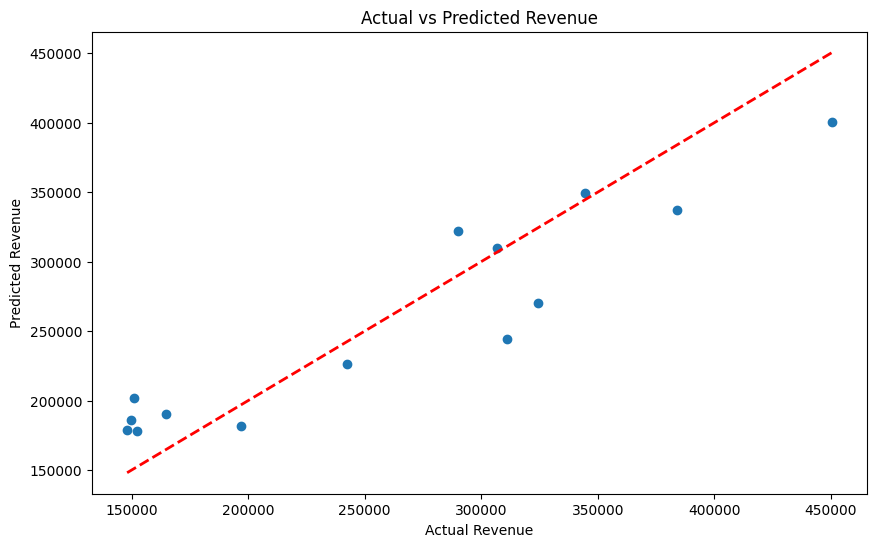

In [7]:
mse = mean_squared_error(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)
mae = mean_absolute_error(Y_test, y_pred)

print("Mean Absolut:", mae)
print("Mean Squared Error:", mse)
print("R-squared Score:", r2)


#Print feature importances
feature_importance = pd.DataFrame({
    'feature': X.columns,
   'importance': model.feature_importances_
})
print("\nFeature Importances:")
print(feature_importance.sort_values('importance', ascending=False))

# Optional: Scatter plot of predicted vs actual Revenue 
plt.figure(figsize=(10,6))
plt.scatter(Y_test, y_pred)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Revenue')
plt.ylabel('Predicted Revenue')
plt.title('Actual vs Predicted Revenue')
plt.show()

Test Max Revenue Scenario 

In [8]:
max_game = pd.DataFrame({col: [0] for col in [
    'Competition_Bundesliga', 
    'Competition_DFB-Pokal', 
    'Competition_UEFA Champions League', 
    'Competition_UEFA Europa Conference League', 
    'Competition_UEFA Europa League', 
    'EventName_AS Roma vs. Eintracht Frankfurt', 
    'EventName_Beşiktaş JK vs. Eintracht Frankfurt', 
    'EventName_Eintracht Frankfurt vs. 1. FC Heidenheim', 
    'EventName_Eintracht Frankfurt vs. 1. FC Heidenheim 1846', 
    'EventName_Eintracht Frankfurt vs. 1. FC Köln', 
    'EventName_Eintracht Frankfurt vs. 1. FC Union Berlin', 
    'EventName_Eintracht Frankfurt vs. 1. FSV Mainz 05', 
    'EventName_Eintracht Frankfurt vs. Aberdeen FC', 
    'EventName_Eintracht Frankfurt vs. Bayer 04 Leverkusen', 
    'EventName_Eintracht Frankfurt vs. Borussia Dortmund', 
    'EventName_Eintracht Frankfurt vs. Borussia Mönchengladbach', 
    'EventName_Eintracht Frankfurt vs. FC Augsburg', 
    'EventName_Eintracht Frankfurt vs. FC Bayern München', 
    'EventName_Eintracht Frankfurt vs. FC RFS', 
    'EventName_Eintracht Frankfurt vs. FC Schalke 04', 
    'EventName_Eintracht Frankfurt vs. FC St. Pauli', 
    'EventName_Eintracht Frankfurt vs. FC Viktoria Plzeň', 
    'EventName_Eintracht Frankfurt vs. Ferencvárosi TC', 
    'EventName_Eintracht Frankfurt vs. HJK Helsinki', 
    'EventName_Eintracht Frankfurt vs. Hertha BSC', 
    'EventName_Eintracht Frankfurt vs. Holstein Kiel', 
    'EventName_Eintracht Frankfurt vs. Leipzig', 
    'EventName_Eintracht Frankfurt vs. Olympique de Marseille', 
    'EventName_Eintracht Frankfurt vs. PAOK FC', 
    'EventName_Eintracht Frankfurt vs. PFC Levski Sofia', 
    'EventName_Eintracht Frankfurt vs. SC Freiburg', 
    'EventName_Eintracht Frankfurt vs. SK Slavia Praha', 
    'EventName_Eintracht Frankfurt vs. SSC Napoli', 
    'EventName_Eintracht Frankfurt vs. SV Darmstadt 98', 
    'EventName_Eintracht Frankfurt vs. SV Werder Bremen', 
    'EventName_Eintracht Frankfurt vs. Sporting Clube de Portugal', 
    'EventName_Eintracht Frankfurt vs. TSG Hoffenheim', 
    'EventName_Eintracht Frankfurt vs. Tottenham Hotspur', 
    'EventName_Eintracht Frankfurt vs. VfB Stuttgart', 
    'EventName_Eintracht Frankfurt vs. VfL Bochum 1848', 
    'EventName_Eintracht Frankfurt vs. VfL Wolfsburg',  
    'EventName_FC Midtjylland vs. Eintracht Frankfurt', 
    'EventName_Olympique Lyonnais vs. Eintracht Frankfurt',
    'Year',
    'Month',
    'DayOfWeek',
    'Hour',
    'Minute'
]})

max_game['Competition_Bundesliga'] = 1  
max_game['EventName_Eintracht Frankfurt vs. FC Bayern München'] = 1

max_game['Year'] = 2034
max_game['Month'] = 5
max_game['DayOfWeek'] = 5
max_game['Hour'] = 20  
max_game['Minute'] = 30  




In [11]:
y_predmax = model.predict(max_game)

print(y_predmax)

[337970.33996786]


In [10]:
average_price = y_predmax/7000

print(average_price)

[48.28147714]


# Negatives 
-> Season Ticket Holder vs Single Game tickets 
-> No dynamic pricing 
-> Data does not indicate demand for a game 
-> How many people wanted to buy tickets vs how many people bought tickets 
-> No correlations to other factors such as weather 
-> Encoding of the individual opponents is not so great since each opponents is only played maximum of about 4 times  
-> No information about how fast Tickets are sold which would indicate a higher demand 

# Positives 
-> Good validity with almost no assumptions 
-> simple 